# Создание датасета

## Загрузка необходимых модулей

In [59]:
import json
import urllib.request
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm, contrib
import random
import numpy as np
import unicodedata
from collections import Counter
import matplotlib.pyplot as plt
from deep_translator import GoogleTranslator
import re
import warnings

In [60]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
pd.options.mode.chained_assignment = None

## Описание данных

In [12]:
with open("../data/records.json", 'r', encoding='utf-8') as file:
    records = json.load(file)

In [13]:
df = pd.DataFrame(records)
df.sample(5)

,id,datetime,digest_number,state,title,description,type,category,keywords,language,url
40738,75900,2021-12-01 13:00:11,NaN,FILTERED,CertiK raises $80M to keep up with increasing ...,\nBlockchain security startup CertiK has raise...,None,None,"[{'name': 'security', 'foss': True, 'generic':...",ENGLISH,https://siliconangle.com/2021/12/01/certik-rai...
4936,65731,2021-11-10 11:00:11,NaN,UNKNOWN,Weekly: Share your EXPLOSIONS thread,Did anything explode this week (or recently)? ...,None,None,[],ENGLISH,https://www.reddit.com/r/kubernetes/comments/q...
32016,37485,2021-09-12 15:46:06,NaN,FILTERED,How to watch Djokovic vs Medvedev: live stream...,Serbian star is on the brink of history - can ...,None,None,"[{'name': 'watch', 'foss': True, 'generic': Fa...",ENGLISH,https://www.techradar.com/news/how-to-watch-dj...
34567,41557,2021-09-20 17:38:42,NaN,FILTERED,Surface Book 4: what we want to see,Will the Surface Book 4 do better in updates t...,None,None,[],ENGLISH,https://www.techradar.com/news/surface-book-4/
76684,14022,2021-07-20 14:18:27,NaN,UNKNOWN,Could Red Hat Leader Jim Whitehurst’s Sudden E...,None,None,None,"[{'name': 'Red Hat', 'foss': True, 'generic': ...",ENGLISH,https://medium.com/@wadhwanisumeet/could-red-h...


In [14]:
df.shape

(76885, 11)

In [15]:
df.category.unique()

array([None, 'WEB', 'SECURITY', 'INTROS', 'DATA_SCIENCE', 'ORG', 'KnD',
       'OPENING', 'DEVOPS', 'GAMES', 'SPECIAL', 'USER', 'EVENTS', 'DEV',
       'MOBILE', 'SYSADM', 'MULTIMEDIA', 'EDUCATION', 'DATABASES',
       'MESSENGERS', 'DIY', 'MANAGEMENT', 'HARDWARE', 'MISC', 'LAW',
       'HISTORY', 'SYSTEM', 'TESTING'], dtype=object)

In [16]:
russianDf = df.loc[(df['language'] == 'RUSSIAN') & (df['category'] != 'SYSTEM')]
russianDf = russianDf[russianDf['category'].notna()]
russianDict = russianDf['category'].value_counts().to_dict()

In [17]:
russianDf.shape

(4998, 11)

In [18]:
englishDf = df.loc[(df['language'] == 'ENGLISH') & (df['category'] != 'TESTING')]
englishDf = englishDf[englishDf['category'].notna()]
englishDict = englishDf['category'].value_counts().to_dict()

In [19]:
englishDf.shape

(3629, 11)

In [81]:
def buildChart(dictionary, string):
    
    x = dictionary.keys()
    y = dictionary.values()
    axis_font = {'size':'13'}
    plt.figure(figsize=(12, 7))
    plt.plot(x, y, 'o-', color='#139CFF', alpha=0.7, lw=5, mec='b', mew=2, ms=10)
    plt.xlabel("категория", **axis_font)
    plt.ylabel("количество веб-страниц", **axis_font)
    plt.xticks(rotation=60, **axis_font)
    plt.title("Количество записей каждой категории" + string)
    plt.grid(True)
    #plt.savefig('pp.jpeg', dpi=300, bbox_inches='tight')
#fig, ax = plt.subplots()
#ax.bar(dictionary.keys(), dictionary.values())
#ax.tick_params(axis='y', labelsize = 15)
#ax.tick_params(axis = 'x',rotation = 30, labelsize = 12)
#fig.set_figwidth(25)  
#fig.set_figheight(12)
#plt.title("Количество записей каждой категории")
#plt.savefig('hist.jpeg', dpi=300, bbox_inches = "tight")
#plt.show()

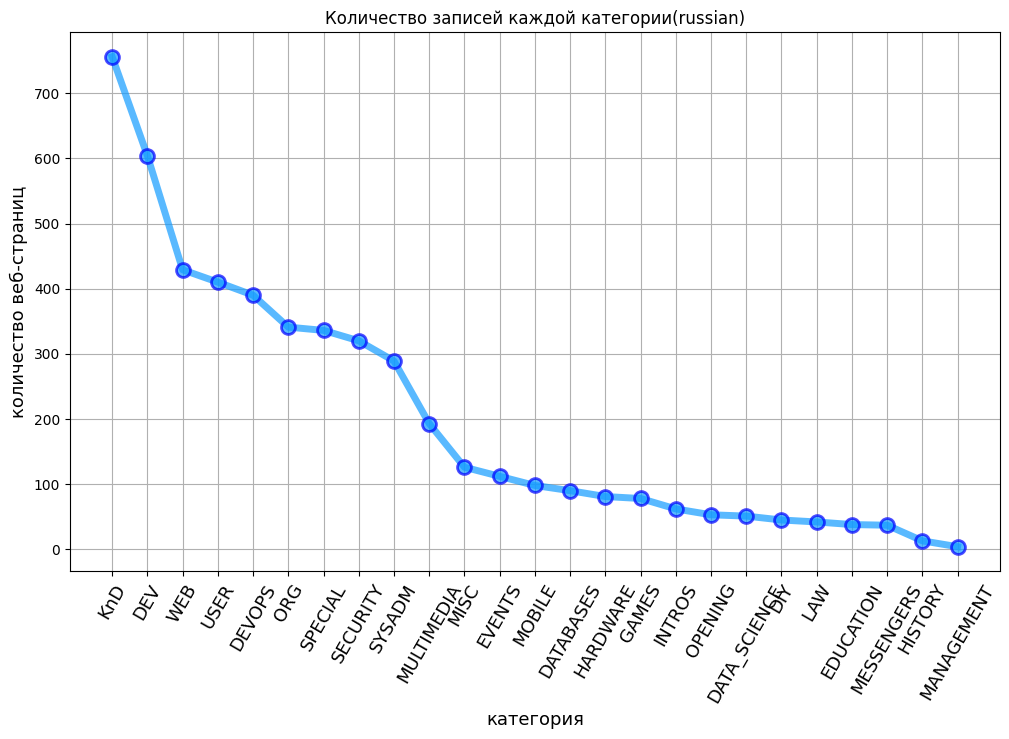

In [21]:
buildChart(russianDict, "(russian)")

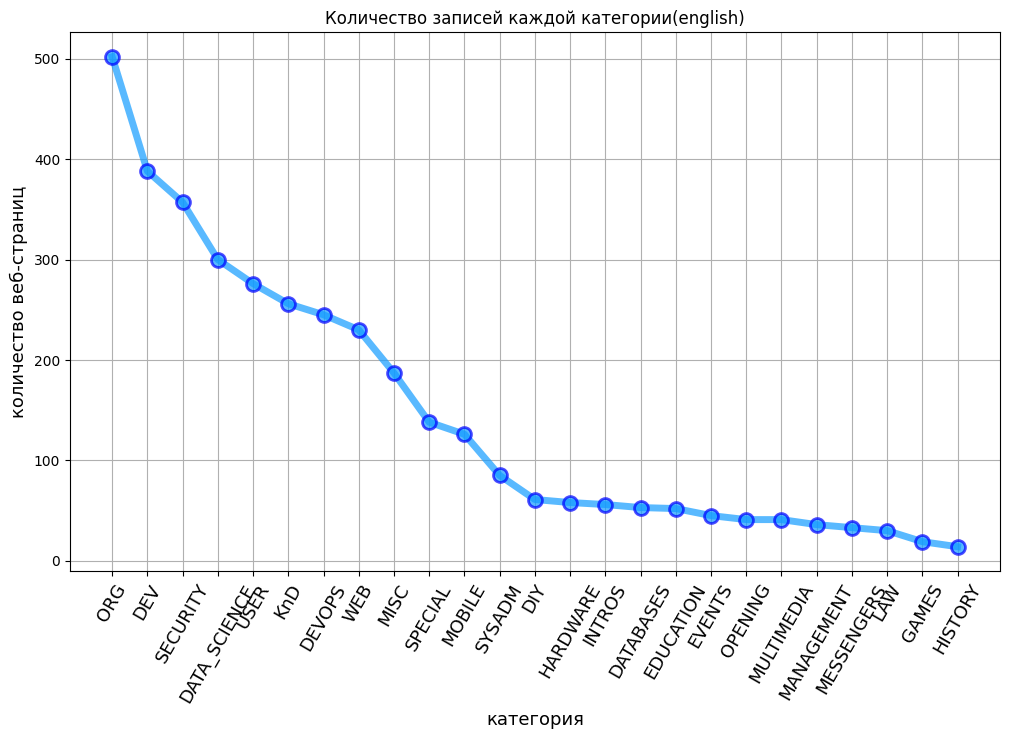

In [22]:
buildChart(englishDict, "(english)")

In [23]:
df = df[df['category'].notna()]
df = df[(df['category'] != 'TESTING') & (df['category'] != 'SYSTEM')].reset_index(drop=True)

In [24]:
categories = df.category.unique()

In [25]:
df.shape

(8627, 11)

## Работа с веб-страницами

In [26]:
class Record(object):
    """класс для хранения 'сжатых' записей"""
    
    def __init__(self, text = '', category = '', url = '', isDownloaded = True, id_ = -1, language = ''):
        self.__text = text
        self.__category = category
        self.__url = url
        self.__id = id_
        self.__isDownloaded = isDownloaded
        self.__language = language
    def toJSON(self):
        return json.dumps(self, default=lambda o: o.__dict__, indent=4)
    def setLanguage(self, language):
        self.__language = language
    def setId(self, id):
        self.__id = id
    def setText(self, text):
        self.__text = text
    def setUrl(self, url):
        self.__url = url
    def setIsDownloaded(self, isDownloaded):
        self.__isDownloaded = isDownloaded
    def setCategory(self, category):
        self.__category = category
    def getLanguage(self):
        return(self.__language)
    def getCategory(self):
        return(self.__category)
    def getUrl(self):
        return(self.__url)
    def getIsDownloaded(self):
        return(self.__isDownloaded)
    def getText(self):
        return(self.__text)

In [69]:
def countDownloadedTexts(records):
    
    textsFalseCount = 0
    for number, record in enumerate(records):
        if record.getIsDownloaded() == False:
            textsFalseCount+=1
    print("Количество не открытых веб-страниц = {}".format(textsFalseCount))

In [70]:
def getContentTextFromFalseDownloaded(url):
    """дополнительная функция для получения текстовых данных из 
    незагрузившихся первоночально веб-страниц"""
    
    userAgent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
    headers={'User-Agent':userAgent,} 
    request = urllib.request.Request(url, None, headers) 
    response = urllib.request.urlopen(request)
    html = response.read()
    finishedText = parsingSoup(html)
    
    return unicodedata.normalize("NFKD", finishedText)   

In [71]:
def getContentTextFromMinLen(url):
    """дополнительная функция для получения текстовых данных 
        с тега <body>"""
    
    userAgent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
    headers={'User-Agent':userAgent,} 
    request = urllib.request.Request(url, None, headers) 
    response = urllib.request.urlopen(request)
    html = response.read()
    soup = BeautifulSoup(html)
    for data in soup(["script", "style"]):
        data.extract()
    allText = soup.body.get_text()
    splitText = allText.splitlines()
    lines = [line.strip() for line in splitText]
    cleanLines = [splitLine.strip() for line in lines for splitLine in line.split("  ")]
    text = "\n".join(line for line in cleanLines if line)
    
    return unicodedata.normalize("NFKD", text) 

In [72]:
def parsingSoup(html):
    
    soup = BeautifulSoup(html)
    for data in soup(["script", "style"]):
        data.extract()
    pTags = soup.find_all('p')
    text = list()
    for p in pTags:
        paragraph = p.get_text()
        if (paragraph != None):
            text.append(paragraph)
            
    return "\n".join(text) #вместо пробела -- \n

In [73]:
def getContentText(url):
    """получение текстовых данных с веб-страницы"""
    
    html = urllib.request.urlopen(url).read()
    
    return parsingSoup(html)

In [74]:
def getTexts(df):
    
    filteredRecords = list()
    finishedText = ""
    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
            record = Record()
            url = row['url']
            try:
                finishedText = getContentText(url)
                finishedText = unicodedata.normalize("NFKD", finishedText)
                record.setText(finishedText)
            except:
                record.setIsDownloaded(False)
            record.setLanguage(row['language'])
            record.setId(row['id'])
            record.setCategory(row['category'])
            record.setUrl(url)
            filteredRecords.append(record)
            
    return filteredRecords

In [33]:
filteredRecords = getTexts(df)

100%|█████████████████████████████████████| 8627/8627 [2:07:43<00:00,  1.13it/s]


In [34]:
pd.DataFrame(filteredRecords[0].__dict__, index=[0])

,_Record__text,_Record__category,_Record__url,_Record__id,_Record__isDownloaded,_Record__language
0,"Пару недель назад (а если быть точнее, то 2 ию...",WEB,https://habr.com/ru/post/570448,18726,True,RUSSIAN


In [35]:
countDownloadedTexts(filteredRecords)

Количество не открытых веб-страниц = 880


In [36]:
finishedText = ""
for record in tqdm(filteredRecords):
     if record.getIsDownloaded() == False: 
        try:
            finishedText = getContentTextFromFalseDownloaded(record.getUrl())
            record.setText(finishedText)
            record.setIsDownloaded(True) 
        except Exception as exception:
            pass

100%|███████████████████████████████████████| 8627/8627 [17:09<00:00,  8.38it/s]


In [53]:
countDownloadedTexts(filteredRecords)

Количество не открытых веб-страниц = 300


In [37]:
list1 = list()
list2 = list()

In [38]:
for _, record in tqdm(enumerate(filteredRecords), total=len(filteredRecords)):
    recordLen = len(record.getText())
    if (recordLen > 0 and recordLen < 1000 and record.getIsDownloaded() == True):
        #dict1[number] = recordLen
        list1.append(recordLen)
        try:
            text = getContentTextFromMinLen(record.getUrl())
            record.setText(text)
            #dict2[number] = len(record.getText())
            list2.append(len(record.getText()))
        except:
            pass
        
print("Количество текстов, длина которых меньше 1000, = {}".format(len(dict1)))

100%|███████████████████████████████████████| 8627/8627 [11:17<00:00, 12.74it/s]

Количество текстов, длина которых меньше 1000, = 937


In [44]:
assert len(list1) == len(list2)

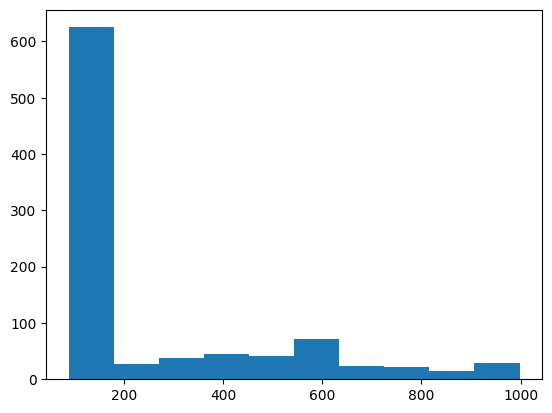

In [45]:
plt.hist(list1)
plt.title('частота некоторых текстов(html <p>)')
plt.show()

In [ ]:
plt.hist(list2)
plt.title('частота некоторых текстов(html <body>)')
plt.show()

### Подготовка данных для датасета

In [ ]:
dictRecords = []
for record in filteredRecords:
    dictRecords.append(record.__dict__)
    
with open('filtred_records.json', 'w', encoding='utf-8') as outfile:
        json.dump(dictRecords, outfile, indent=4, ensure_ascii=False)

In [48]:
cleanDf = pd.DataFrame(record.__dict__ for record in filteredRecords)

In [49]:
cleanDf.columns = ['document', 'category', 'url', 'id', 'isDownloaded', 'language']

In [ ]:
#finalDf.drop([841, 7609], inplace=True)
#finalDf = finalDf.reset_index(drop=True)

In [64]:
cleanDf = cleanDf[cleanDf.isDownloaded == True].reset_index(drop=True)

In [65]:
cleanDf.shape

(8328, 6)

In [66]:
cleanDf['textLen'] = [-1]*cleanDf.shape[0]

In [67]:
for i in tqdm(range(0, len(cleanDf))):
    cleanDf['textLen'][i] = len(cleanDf['document'][i])

100%|█████████████████████████████████████| 8328/8328 [00:01<00:00, 5084.71it/s]


In [68]:
cleanDf = cleanDf[cleanDf.textLen != 0].reset_index(drop=True)

In [69]:
cleanDf.shape

(8051, 7)

## Перевод английских текстов на русский язык

In [82]:
def getPartText(text, maxPosition, start):
    
    if (len(text) < maxPosition):
        return (text[start:len(text)], -1, -1) 
    textChunk = text[start:maxPosition]
    j = maxPosition - (5000 - textChunk.rfind('.')) 
    
    return (text[start:j], j+1+5000,  j+1)

In [83]:
error = list()
#englishTexts = list(' ')*3500

In [84]:
def getTranslateTexts(df):
    
    resultDf = df.copy()
    for number, row in tqdm(resultDf.iterrows(), total=resultDf.shape[0]):
        if (row['language'] == 'ENGLISH'):
            text = row['document']
            try:
                if (len(text) >= 5000):
                    textChunks = list()
                    maxPosition = 5000
                    start = 0
                    for d in range(0, len(text) // 5000 + 1):
                        (result, maxPosition, start) = getPartText(text, maxPosition, start)
                        textChunks.append(result)
                    translateText = GoogleTranslator(source='en', target='ru').translate_batch(textChunks) 
                    translateText = " ".join(translateText)
                else:
                    translateText = GoogleTranslator(source='en', target='ru').translate(text)
                resultDf['document'][number] = translateText
            except Exception as exception:
                error.append(number)
                
    return resultDf

In [86]:
finalDf = getTranslateTexts(cleanDf)

100%|█████████████████████████████████████| 8051/8051 [1:26:24<00:00,  1.55it/s]


In [87]:
finalDf.drop(error[0], inplace=True)
finalDf = finalDf.reset_index(drop=True)

In [116]:
finalDf.drop_duplicates(subset=['document'], keep=False, inplace=True)

## Формирование датасета

In [117]:
finalDf.drop(columns=['id', 'language', 'textLen', 'url', 'isDownloaded'], inplace=True) 

In [125]:
finalDf = finalDf.reset_index(drop=True)
finalDf.shape

(7980, 2)

In [130]:
#finalDf.to_csv('../datasets/foss/dataset_{}_{}.csv'.format('max', 25))

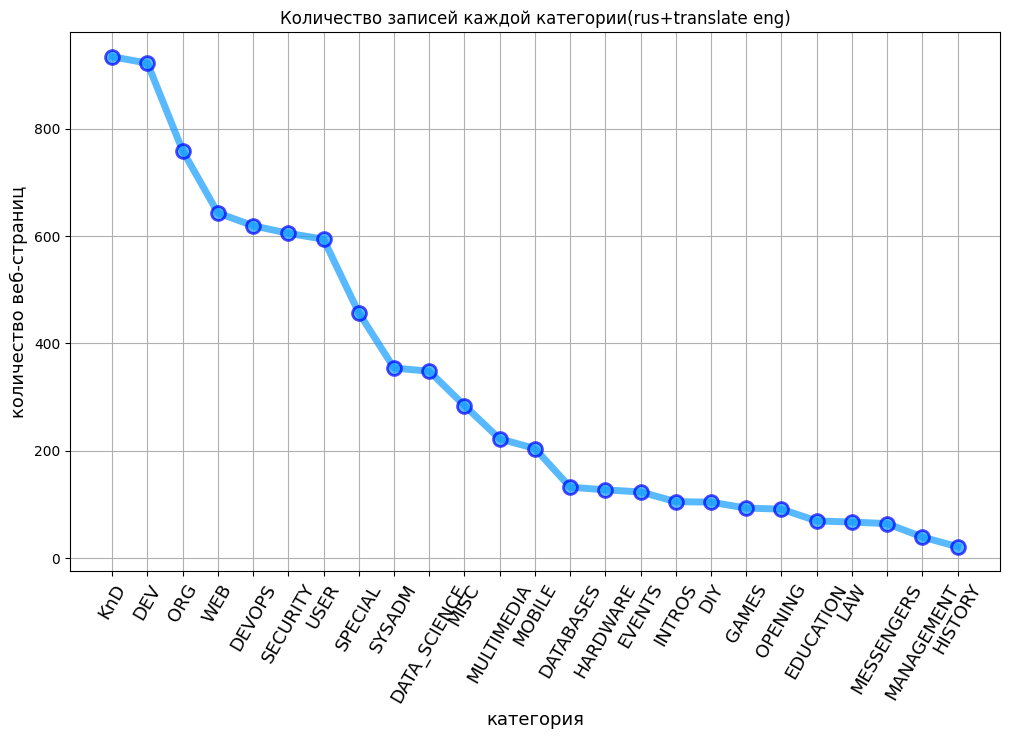

In [120]:
tempDict = finalDf['category'].value_counts().to_dict()
buildChart(tempDict, "(rus+translate eng)")

In [102]:
def getRecodrsOfCategory(count, df, category):
    """получить count записей category"""
    
    result = list()
    categoryDf = cleanDf.groupby('category', group_keys=True).get_group(category)
    categoryDf = categoryDf.reset_index(drop=True)
    lenCategoryDf = categoryDf.shape[0]
    numbers = list(range(lenCategoryDf))
    random.shuffle(numbers)
    if (lenCategoryDf > count):
        numbers = numbers[0:count]
    for number in numbers: 
        newRow = df.iloc[number]
        result.append(newRow)
        
    return pd.DataFrame(result)

In [103]:
def createDataset(df, maxCount, minCount):
    
    """выход: датасет, который содержит count документов каждой из categories"""
    newDf = pd.DataFrame({'category': [], 'document': []})
    categories = df.category.unique()
    for category in categories:
        if (len(df[df.category == category]) > minCount):
            result = getRecodrsOfCategory(maxCount, df, category)
            newDf = pd.concat([newDf, result], ignore_index=True)
            
    return newDf

In [104]:
maxCount = 2000
minCount = 0
dataset = createDataset(finalDf, maxCount, minCount)

In [105]:
assert dataset.shape == finalDf.shape
dataset.to_csv('datasets/foss/dataset_{}_{}.csv'.format('max', 25))

## Датасет, основанный на материалах с lenta.ru

In [34]:
df = pd.read_csv('../data/lenta_ru_news.csv', low_memory=False, index_col=0)

In [35]:
df

,url,text,topic
0,https://lenta.ru/news/1914/09/16/hungarnn/,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека
1,https://lenta.ru/news/1914/09/16/lermontov/,"Министерство народного просвещения, в виду про...",Библиотека
2,https://lenta.ru/news/1914/09/17/nesteroff/,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека
3,https://lenta.ru/news/1914/09/17/bulldogn/,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека
4,https://lenta.ru/news/1914/09/18/zver/,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека
...,...,...,...
712649,https://lenta.ru/news/2018/12/15/gasinparis/,Протесты движения «желтых жилетов» в Париже сн...,Мир
712650,https://lenta.ru/news/2018/12/15/su27/,Истребитель Су-27 разбился в Житомирской облас...,Бывший СССР
712651,https://lenta.ru/news/2018/12/15/spb/,В Московском районе Санкт-Петербурга на продаж...,Дом
712652,https://lenta.ru/news/2018/12/15/gizin/,Швейцарский горнолыжник Марк Гизин неудачно пр...,Спорт


In [36]:
d = []
for i in range(0, df.shape[0]):
    d.append(df['topic'][i])   

In [37]:
counter = Counter(d)

In [38]:
counter

Counter({'Библиотека': 65,
         'Россия': 155004,
         'Мир': 136620,
         'Экономика': 76423,
         'Интернет и СМИ': 44421,
         'Спорт': 57894,
         'Культура': 53530,
         'Из жизни': 27513,
         'Наука и техника': 53136,
         'Бывший СССР': 51370,
         'Дом': 21734,
         'Сочи': 1,
         'ЧМ-2014': 2,
         'Путешествия': 6370,
         'Силовые структуры': 11223,
         'Ценности': 7581,
         'Легпром': 114,
         'Бизнес': 7375,
         'МедНовости': 1,
         'Оружие': 3,
         '69-я параллель': 1268,
         'Культпросвет ': 340,
         'Крым': 666})

In [39]:
drop_categories = ['Оружие', 'Библиотека', 'Сочи', 'ЧМ-2014', 'Леегпром', 'МедНовости', 'Оружие']
for drop_ct in drop_categories:
    
    df = df.drop(df[df.topic == drop_ct].index).reset_index(drop=True)

In [40]:
d = []
for i in range(0, df.shape[0]):
    d.append(df['topic'][i])   

In [41]:
counter = Counter(d)

In [48]:
list_categories = list(counter.keys())
list_values = list()
for ct in list_categories:
    if counter[ct] > 1000:
        list_values.append(1200)
    else:
        list_values.append(counter[ct])

In [61]:
fin_df = pd.DataFrame(columns=['url', 'text', 'topic'])

In [62]:
for category, values in zip(list_categories, list_values):
    df1 = df[df.topic == category][0:values]
    fin_df = fin_df.append(df1, ignore_index=True)

In [64]:
fin_df.shape

(19120, 3)

In [65]:
fin_df.columns = ['url', 'document', 'category']

In [76]:
for _, row in tqdm(fin_df.iterrows(), total=fin_df.shape[0]):
        url = row['url']
        try:
            finishedText = getContentText(url)
            finishedText = unicodedata.normalize("NFKD", finishedText)
            row['document'] = finishedText
        except:
            continue
        break

  0%|                                                 | 0/19120 [00:00<?, ?it/s]

Как стало известно агентству Ассошиэйтед Пресс, экипаж последней экспедиции на станцию "Мир" считает ее способной выйти из-под контроля.Командир Виктор Афанасьев сказал: "Мы чувствуем себя хорошо, но грустим, что оставили станцию летать в беспилотном режиме."
Gazeta Ru подробно писала о том, что финансирование программы "Мир" закрыто, но конструкторы не спешат топить ее в Тихом океане, надеясь на изыскание внебюджетных средств.Они надеются, что правительство оплатит финальную экспедицию на "Мир" в феврале или марте 2000 года.
Новая экспедиция должна постепенно перевести станцию на низкую орбиту, после чего 140- тонный "Мир" в основном сгорит в атмосфере, а незначительные его части упадут в Тихий океан.
Но нет никакой гарантии, что пережившая столько отказов оборудования конструкция поведет себя адекватно командам.
Афанасьев перечислил потенциально опасные элементы "Мира" на пресс- конференции, состоявшейся в понедельник в Звездном Городке.
"Может упасть давление в кабине,- сказал он,- 

In [77]:
fin_df.to_csv(../datasets/'lenta_18_with_urls.csv')

In [67]:
df = fin_df.drop(columns=df.columns[0], axis= 1 , inplace=False)

In [80]:
df.to_csv('../datasets/lenta_18.csv')

In [82]:
lentaDict = df['category'].value_counts().to_dict()

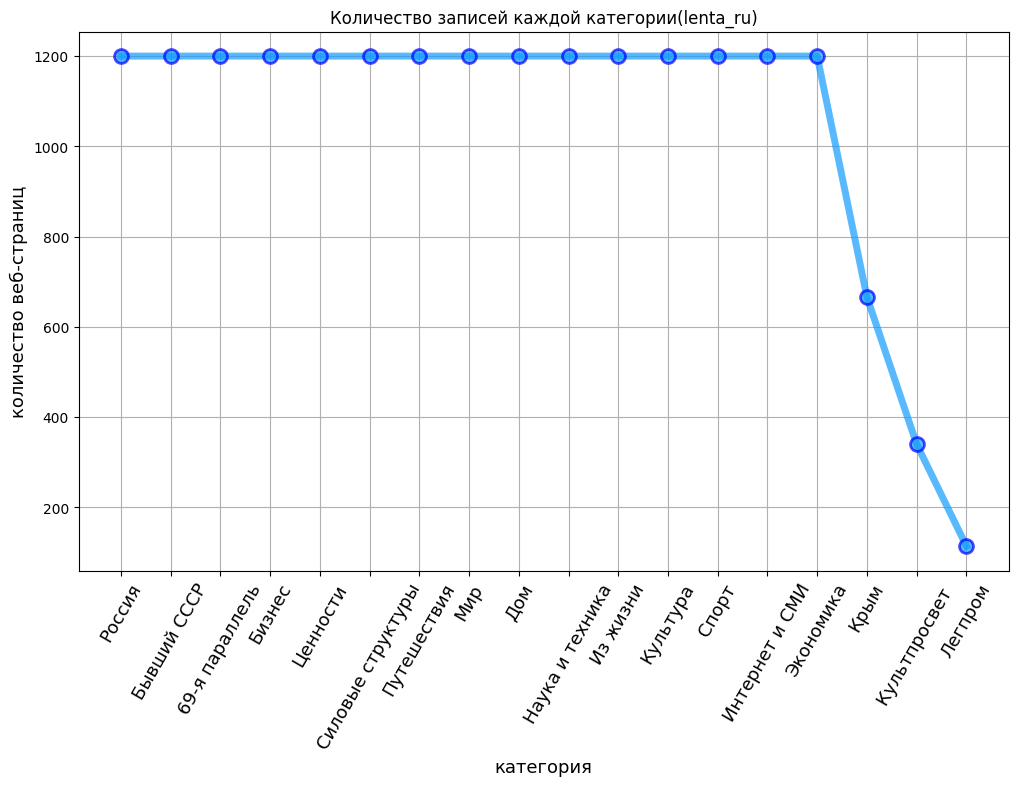

In [83]:
buildChart(lentaDict, "(lenta_ru)")